In [3]:
import os, sys, warnings, logging, json, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path

warnings.filterwarnings("ignore")
plt.style.use("ggplot")
sns.set_palette("viridis")

In [4]:

ROOT  = Path.cwd().parent if Path.cwd().name.lower()=="notebook" else Path.cwd()
PROC  = ROOT / "data" / "processed"

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")

In [5]:
X_train = pd.read_csv(PROC / "X_train.csv")
y_train = pd.read_csv(PROC / "y_train.csv").squeeze("columns")
X_valid = pd.read_csv(PROC / "X_valid.csv")
y_valid = pd.read_csv(PROC / "y_valid.csv").squeeze("columns")
test_df = pd.read_csv(PROC / "test_processed.csv")

logging.info(f"X_train shape : {X_train.shape}")
logging.info(f"X_valid shape : {X_valid.shape}")
logging.info(f"Test     shape : {test_df.shape}")

# Merge labels for convenience
train_df = X_train.assign(prognosis=y_train)

INFO | X_train shape : (3936, 134)
INFO | X_valid shape : (984, 134)
INFO | Test     shape : (42, 135)


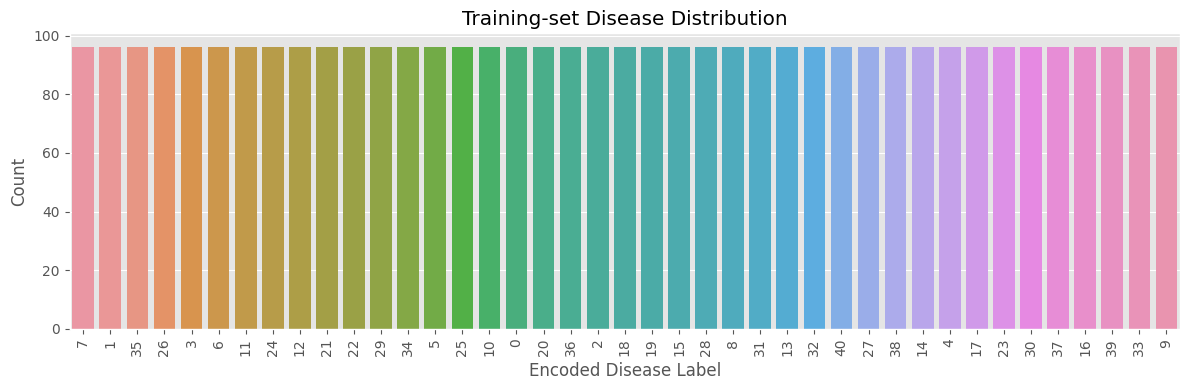

Top-5 most common diseases:
 prognosis
7     96
1     96
35    96
26    96
3     96
Name: count, dtype: int64


In [6]:
plt.figure(figsize=(12,4))
sns.countplot(x=y_train, order=y_train.value_counts().index)
plt.title("Training-set Disease Distribution")
plt.xlabel("Encoded Disease Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Top-5 most common diseases:\n", y_train.value_counts().head())


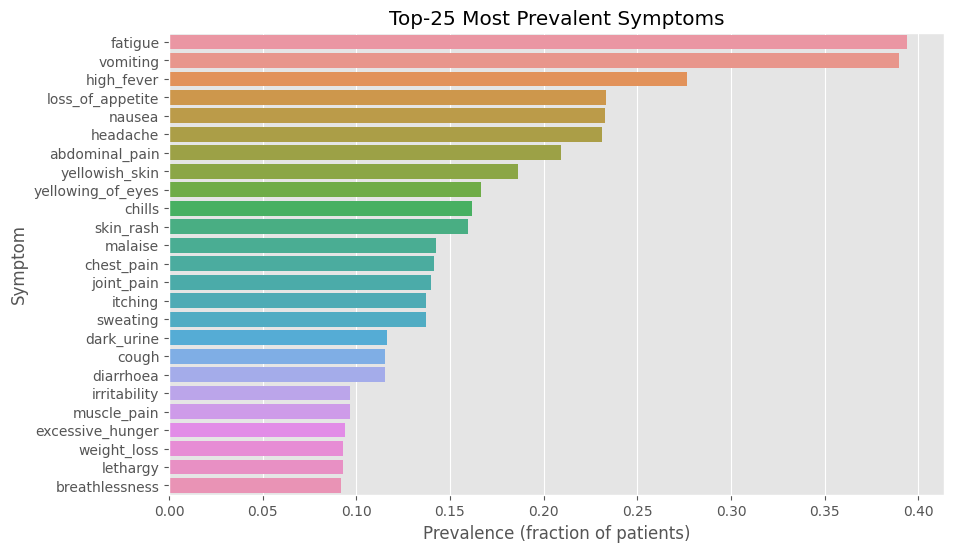

In [7]:
symptom_cols = X_train.columns.difference(["symptom_count",
                                           "rare_symptom_flag",
                                           "fever_cough"])  # keep engineered features separate

symptom_freq = X_train[symptom_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(y=symptom_freq.index[:25],
            x=symptom_freq.values[:25])
plt.title("Top-25 Most Prevalent Symptoms")
plt.xlabel("Prevalence (fraction of patients)")
plt.ylabel("Symptom")
plt.show()

In [8]:
rare_syms = symptom_freq[symptom_freq<0.01]
print(f"Number of rare symptoms (<1 %): {rare_syms.shape[0]}")

Number of rare symptoms (<1 %): 1


In [9]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X_bin = X_train[symptom_cols].copy()
X_bin = MinMaxScaler().fit_transform(X_bin)     # chi2 expects non-negative
chi_scores, p_values = chi2(X_bin, y_train)

chi_df = (pd.DataFrame({"symptom": symptom_cols,
                        "chi2": chi_scores,
                        "p_value": p_values})
          .sort_values("chi2", ascending=False))

display(chi_df.head(15))

,symptom,chi2,p_value
76,pain_behind_the_eyes,3840.0,0.0
99,sinus_pressure,3840.0,0.0
94,runny_nose,3840.0,0.0
92,redness_of_eyes,3840.0,0.0
63,loss_of_smell,3840.0,0.0
117,throat_irritation,3840.0,0.0
22,congestion,3840.0,0.0
49,increased_appetite,3840.0,0.0
84,polyuria,3840.0,0.0
88,receiving_blood_transfusion,3840.0,0.0


In [10]:
top_sym1, top_sym2 = chi_df.symptom.iloc[0], chi_df.symptom.iloc[1]
fig = px.scatter(train_df,
                 x=top_sym1, y=top_sym2,
                 color="prognosis",
                 title=f"{top_sym1} vs {top_sym2} coloured by disease")
fig.show()

In [11]:
co_matrix = X_train[symptom_cols].T.dot(X_train[symptom_cols])
np.fill_diagonal(co_matrix.values, 0)   # remove self-loops

# Keep strong links only
threshold = 50   # tweak based on dataset size
edges = np.where(co_matrix > threshold)
edges_df = pd.DataFrame({
    "symptom1": co_matrix.index[edges[0]],
    "symptom2": co_matrix.columns[edges[1]],
    "weight":   co_matrix.values[edges]
})
print(f"Edges with >{threshold} co-occurrences:", edges_df.shape[0])

Edges with >50 co-occurrences: 1888


In [12]:
# Plot network with Plotly
import networkx as nx
G = nx.from_pandas_edgelist(edges_df, "symptom1", "symptom2", ["weight"])
pos = nx.spring_layout(G, seed=42)

edge_x, edge_y = [], []
for e in G.edges():
    x0, y0 = pos[e[0]]
    x1, y1 = pos[e[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x, node_y = zip(*[pos[k] for k in G.nodes()])
node_connections = [len(list(G.neighbors(n))) for n in G.nodes()]

edge_trace = dict(type='scatter',
                  x=edge_x, y=edge_y,
                  line=dict(width=0.5, color='#888'),
                  hoverinfo='none',
                  mode='lines')

node_trace = dict(type='scatter',
                  x=node_x, y=node_y,
                  mode='markers',
                  marker=dict(size=[v*2 for v in node_connections],
                              color=node_connections,
                              colorscale='Viridis',
                              showscale=True),
                  text=list(G.nodes()))

import plotly.graph_objects as go
fig_net = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(showlegend=False,
                                     title="Symptom Co-Occurrence Network",
                                     hovermode="closest"))
fig_net.show()

INFO | X_train shape : (3936, 134)
INFO | X_valid shape : (984, 134)
INFO | Test     shape : (42, 135)


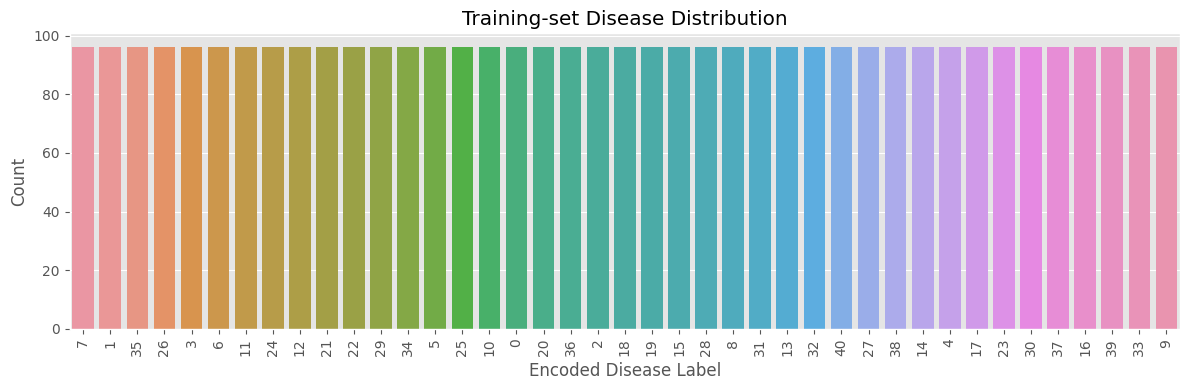

Top-5 most common diseases:
 prognosis
7     96
1     96
35    96
26    96
3     96
Name: count, dtype: int64


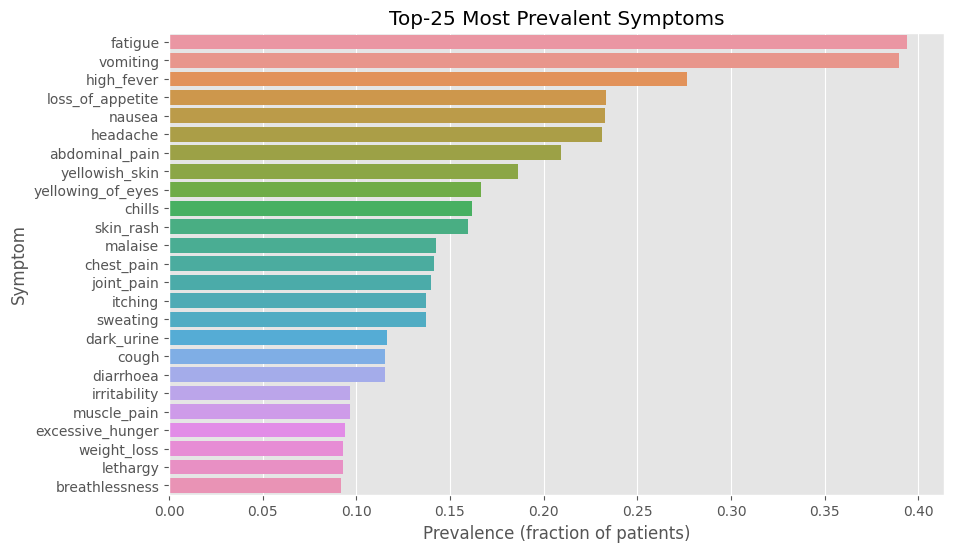

Number of rare symptoms (<1 %): 1


,symptom,chi2,p_value
76,pain_behind_the_eyes,3840.0,0.0
99,sinus_pressure,3840.0,0.0
94,runny_nose,3840.0,0.0
92,redness_of_eyes,3840.0,0.0
63,loss_of_smell,3840.0,0.0
117,throat_irritation,3840.0,0.0
22,congestion,3840.0,0.0
49,increased_appetite,3840.0,0.0
84,polyuria,3840.0,0.0
88,receiving_blood_transfusion,3840.0,0.0


Edges with >50 co-occurrences: 1888


In [ ]:
# ======================================================================
# exploratory_data_analysis.ipynb  |  Disease-Prediction Mini-Hackathon
# Author: <your name>              |  Python 3.10.11
# ======================================================================

# %% [markdown]
# # 1 – Imports & Configuration
#   • Loads the processed datasets  
#   • Sets global plotting style

# %%



# %% [markdown]
# # 2 – Load Processed Data

# %%


# %% [markdown]
# # 3 – Target (Disease) Distribution

# %%

# %% [markdown]
# # 4 – Symptom Prevalence Heatmap
# Shows how frequently each symptom occurs in the dataset.

# %%


# %% [markdown]
# ## 4.1 Rare Symptoms ( < 1 % )

# %%


# %% [markdown]
# # 5 – Correlation Between Symptoms & Diseases
# Use point-biserial correlation (binary vs multiclass) via `chi2` stats.

# %%


# %% [markdown]
# # 6 – Interactive Exploration with Plotly
# Example: visualising two top symptoms vs disease.

# %%


# %% [markdown]
# # 7 – Symptom Co-Occurrence Network (Optional)
# Creates a network graph of symptoms that often appear together.

# %%
# Compute simple co-occurrence matrix




# %% [markdown]
# # 8 – Key Findings & Notes
# - Imbalance exists: note particularly rare diseases.  
# - Top predictive symptoms (by χ²) provide guidance for feature selection.  
# - Symptom_count and rare_symptom_flag distributions suggest value for models.  
# - Co-occurrence network highlights symptom clusters (potential interactions).  

# ======================================================================
# End of notebook
# ======================================================================
